In [1]:
from dotenv import load_dotenv

load_dotenv()

DATA_DIR = "../data/social"

def data_file(name: str) -> str: return f"{DATA_DIR}/{name}.json"

## Data Aggregation (TikTok)

First we want to collect a set of TikTok posts to use for developing our social media post encoder. To do this, we will need to extract the `item_list` request that is used by the TikTok webapp to request video content during the infinite scroll on the For You Page. We can use inspect element to grab the URLs of these requests as we scroll on the For You Page. Then, by copying and pasting this URL into our python code, we can retrieve all the relevant metadata for the posts we are being fed by TikTok. 

This will provide us with plenty of video metadata, which we can then clean to only save the videos that have longer, more relevant metadata.

In [2]:
import json
import requests


def extract_data(data: dict) -> dict:
    extracted_data = {
        "id": data['id'],
        "description": data['desc'],
        "author": {
            "id": data['author']['id'],
            "name": data['author']['nickname'],
            "signature": data['author']['signature'],
        }
    }

    return extracted_data

def save_results(results) -> None:
    data = results['itemList']

    with open(data_file("tik_tok"), "r", encoding="utf-8") as tik_tok:
        current_data = json.load(tik_tok)

    with open(data_file("tik_tok"), "w", encoding="utf-8") as tik_tok:
        extracted_data = [extract_data(item) for item in data]
        current_data.extend(extracted_data)
        json.dump(current_data, tik_tok, indent=4)
        print(f"Added {len(extracted_data)} new results to tik_tok.json. Total results: {len(current_data)}")


def pipeline() -> None:
    url = input("Enter the url: ")
    print("Requesting data...")
    results = requests.get(url)

    if results.status_code == 200:
        save_results(results.json())

    else:
        print(f"Error: ({results.status_code}) {results.text})")

In [3]:
# pipeline()1

# Check for duplicates
with open(data_file("tik_tok"), "r", encoding="utf-8") as tik_tok:
    data = json.load(tik_tok)

    ids = [item['id'] for item in data]
    print(f"Total results: {len(ids)}")
    print(f"Unique results: {len(set(ids))}")

Total results: 108
Unique results: 107


## Data Cleaning
Now that we have the data aggregated through our pipeline, we want to create a cleaning pipeline to remove all the entries with short description and limited metadata. Let's begin by doing some EDA on our dataset.

In [4]:
import pandas as pd
import tiktoken

def load_data() -> pd.DataFrame:
    with open(data_file("tik_tok"), "r", encoding="utf-8") as tik_tok:
        data = json.load(tik_tok)

    df = pd.DataFrame(data)
    return df

def annotate_data(df: pd.DataFrame) -> pd.DataFrame:
    enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

    df['description_length'] = df['description'].apply(lambda val: len(enc.encode(val)))
    df['author_signature_length'] = df['author_signature'].apply(lambda val: len(enc.encode(val)))

    return df

def overwrite_results(results) -> None:
    with open(data_file("tik_tok"), "w", encoding="utf-8") as tik_tok:
        json.dump(results, tik_tok, indent=4)
        print(f"Overwrote results in tik_tok.json. Total results: {len(results)}")

def clean_pipeline():
    data = load_data()
    df = annotate_data(data)

    start = len(df)

    # Filter out all rows with description length < 30
    df = df[df['description_length'] > 30]
    # Filter out all rows with author signature length < 20
    df = df[df['author_signature_length'] > 20]

    end = len(df)

    print(f"Filtered out {start - end} rows.")

    # Convert the dataframe back into a JSON object
    data = json.loads(df.to_json(orient="records"))
    overwrite_results(data)

In [5]:
# clean_pipeline()

In [6]:
def post_query_term(row: pd.Series):
    return f"{row['author_name']} - {row['description']} - {row['author_signature']}"

In [7]:
from keywords import KeywordVectorstore

df = load_data()
df['search_term'] = df.apply(post_query_term, axis=1)
search_terms = df['search_term'].tolist()

vs = KeywordVectorstore()

relevant_keywords = vs.get_keywords(search_terms)
relevant_keywords

[[('VibrantScenes', 0.7642683442362352),
  ('OffTheBeatenPath', 0.7617780458509142),
  ('ScenicBeauty', 0.7582992638346576)],
 [('CelebrityStyle', 0.7554297178586113),
  ('ChillOut', 0.7534694768216426),
  ('LaughOutLoud', 0.7511796549763081)],
 [('NatureLover', 0.7511458183123062),
  ('EclecticMix', 0.7476282977608115),
  ('ExtremeSports', 0.7449673217228049)],
 [('ExtremeSports', 0.7812182984819501),
  ('GlamNights', 0.7674853750169462),
  ('VibrantScenes', 0.7642640200424451)],
 [('HappyHours', 0.7422962397988337),
  ('TrendySpots', 0.7396016931455938),
  ('DjBeats', 0.7345034937647483)],
 [('LaughOutLoud', 0.7645460398094078),
  ('GlamNights', 0.737469766166932),
  ('LiveMusic', 0.7362374663213882)],
 [('ExtremeSports', 0.7667359577524835),
  ('GlamNights', 0.7554148087547947),
  ('GroupFun', 0.7520289222917531)],
 [('SocialGatherings', 0.7574341111617414),
  ('GlamNights', 0.7555248493442075),
  ('TrendySpots', 0.7547436363036898)],
 [('ComfortFood', 0.7685578206780699),
  ('Chill

In [17]:
keyword_map = {}
for keyword_set in relevant_keywords:
    words = [word for word, score in keyword_set]

    for word in words:
        if word not in keyword_map:
            keyword_map[word] = 1
        else:
            keyword_map[word] += 1

df = pd.DataFrame.from_dict(keyword_map, orient="index", columns=["count"])

array([[<Axes: title={'center': 'count'}>]], dtype=object)

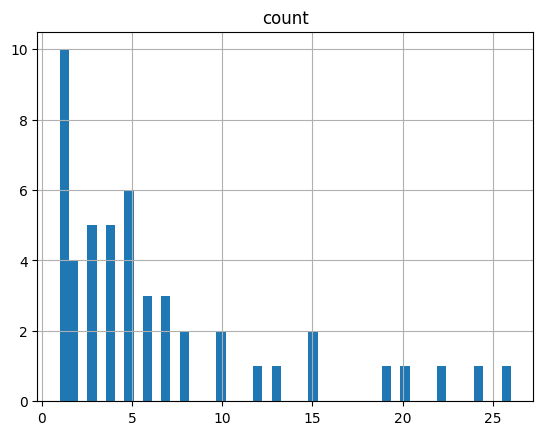

In [18]:
df.hist(bins=49)